## **Ensemble Methods**

### **Introduction**  

You are a data analyst at a **financial services company**, tasked with improving the effectiveness of a **marketing campaign** that promotes term deposit subscriptions. Your goal is to build a **machine learning model** that predicts whether a customer will subscribe to a term deposit based on their demographics, banking history, and previous interactions with the campaign.  

To improve prediction accuracy and model robustness, you will explore three **ensemble methods**:  

- **AdaBoost**  
- **XGBoost**  
- **Random Forest**  

At the end of the assignment, you will analyze and compare the performance of these models and recommend the best approach for **optimizing marketing outreach** and improving customer conversion rates.  

### **Dataset**  

To accomplish this task, you will use the **Bank Marketing Dataset** from Kaggle:  

🔗 **Dataset Link:** [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data)  You can review the annotations about the dataset on the Kaggle site but the CSV file is also provided with your assignment.

This dataset consists of **over 11,000 customer records**, each containing demographic and financial attributes, as well as details of previous marketing interactions. The key features in this dataset include:  

- **Age**: Customer’s age.  
- **Job**: Type of job (e.g., admin, blue-collar, technician, services).  
- **Marital Status**: Single, married, or divorced.  
- **Education**: Level of education attained.  
- **Balance**: Customer's account balance.  
- **Housing Loan**: Whether the customer has a housing loan (yes/no).  
- **Personal Loan**: Whether the customer has a personal loan (yes/no).  
- **Contact Method**: Communication type (e.g., cellular, telephone).  
- **Last Campaign Outcome**: Result of the previous marketing campaign.  
- **Duration**: Call duration in seconds.  

The **target variable** is **"deposit"**, which indicates whether the customer subscribed to a term deposit (**1/0**).  

### **Task**  

Your objective is to develop and compare different **ensemble learning models** to predict whether a customer will subscribe to a term deposit and determine which model performs best for **targeted marketing optimization**.  


In [2]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from xgboost import XGBClassifier
import time

#### **Utilizing the provided Bank Marketing Dataset data, we will employ methods from sklearn for cross-validation to estimate error.**



In [3]:
df = pd.read_csv('files/bank.csv')

In [3]:
# Print the shape
df.shape

(11162, 17)

In [4]:
# Print head of DF
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## **Q1: Exploratory Data Analysis (EDA)**

Explore the dataset.

**1.1 Class Distribution**  
- Plot the distribution of the target variable (`deposit`).  

**1.2 Unique Values & Data Quality Check**  
- Display the unique values for at least two categorical features (e.g., `job` and `education`).

**1.3 Grouped Analysis**
- Use **groupby()** to analyze the average **balance** of customers based on their **education** level.
- Do the same thing for **marital** status. Print both values.

**1.4 Visualizing a Numerical Feature**  
- Plot the `age` column to observe the distribution of customer ages.  

<Axes: ylabel='deposit'>

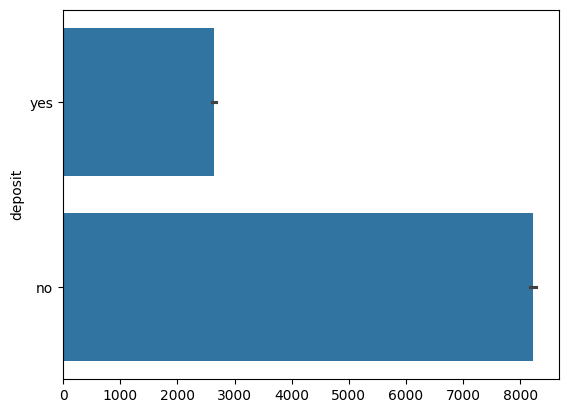

In [5]:
# 1.1 Class Distribution
sns.barplot(df['deposit'])

In [8]:
# 1.2 Unique Values & Data Quality Check
df[['job', 'education']].value_counts()

job            education
management     tertiary     2178
technician     secondary    1209
blue-collar    secondary    1116
admin.         secondary    1084
services       secondary     746
blue-collar    primary       694
technician     tertiary      521
retired        secondary     314
               primary       277
management     secondary     238
self-employed  tertiary      230
unemployed     secondary     210
student        secondary     189
admin.         tertiary      168
housemaid      primary       144
entrepreneur   secondary     141
retired        tertiary      140
self-employed  secondary     136
entrepreneur   tertiary      132
blue-collar    unknown        86
management     unknown        84
unemployed     tertiary       84
student        tertiary       83
services       primary        83
housemaid      secondary      78
student        unknown        67
management     primary        66
unemployed     primary        56
services       tertiary       53
technician     unknown        52
blue-collar    tertiary       48
retired        unknown        47
housemaid      tertiary       43
admin.         primary        42
services       unknown        41
entrepreneur   primary        41
technician     primary        41
admin.         unknown        40
unknown        unknown        39
self-employed  primary        28
student        primary        21
unknown        secondary      15
entrepreneur   unknown        14
self-employed  unknown        11
housemaid      unknown         9
unknown        tertiary        9
unemployed     unknown         7
unknown        primary         7
Name: count, dtype: int64

In [9]:
# 1.3 Average Balance by Education
edu_balance = df.groupby('education')['balance'].mean()
print("\nAverage Balance by Education Level:", edu_balance)

mar_balance = df.groupby('marital')['balance'].mean()
print("\nAverage Balance by Marital Status:", mar_balance)


Average Balance by Education Level: education
primary      1523.031333
secondary    1296.480278
tertiary     1845.869070
unknown      1746.605634
Name: balance, dtype: float64

Average Balance by Marital Status: marital
divorced    1371.835267
married     1599.927570
single      1457.255259
Name: balance, dtype: float64


<Axes: xlabel='age', ylabel='Count'>

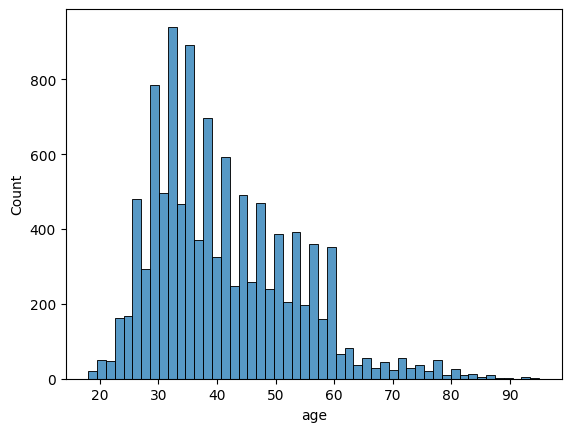

In [10]:
# 1.4 Age Distribution Histogram
sns.histplot(data=df, x='age')

## **Q2 Data Pre-Processing**

This section focuses on preparing the data by encoding categorical features and ensuring it is ready for modeling.

### **2.1 Encode Categorical Variables**
- Identify categorical columns that contain non-numeric values.
- Convert categorical features into **numerical** format using [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Feel free to look at the documentation to get a better idea on what we are doing in this step.
- Store the encoders to allow potential inverse transformations if needed later.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Get categorical columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.to_list()

# Encode categorical features using Label Encoding
label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])  # convert categorical into numerical
  label_encoders[col] = le             # store encoder

## **Q3 Partition the data for cross validation**

Import the dataset and divide it into two parts: 𝑋 (features, stored in `df_X`) and 𝑦 (target, stored in `s_y`). Establish our data partitions.

Given the significant imbalance in the dataset, there's concern about the target class being insufficiently represented in a random k-fold split. To address this, we opt for a [stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) approach, which ensures the preservation of class proportions across our tests. We'll use `𝑘=3`. Create a `StratifiedKFold` instance and utilize its `split` method to fill the training and testing dictionaries.

   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [12]:
df_X = df.drop(columns=["deposit"])
s_y = df["deposit"]
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)


d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()
k = 1

# generate and store k folds
for k, (train_index, test_index) in enumerate(skf.split(df_X, s_y), 1):
  d_train_df_X[k] = df_X.iloc[train_index]  # training features (indices) for each fold
  d_test_df_X[k] = df_X.iloc[test_index]    # test features
  d_train_s_y[k] = s_y.iloc[train_index]  # training targets
  d_test_s_y[k] = s_y.iloc[test_index]    # test targets

In [13]:
# Observe the test data and verify that the target training is as equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

deposit
0    1958
1    1763
Name: count, dtype: int64
deposit
0    1958
1    1763
Name: count, dtype: int64
deposit
0    1957
1    1763
Name: count, dtype: int64


## **Q3: Implementing AdaBoost and Random Forest Classifiers using a Generalized Function**

### **Overview**
As we learned in class, ensemble methods combine multiple models to improve overall prediction performance. In this assignment, you will work with two ensemble methods:

1. **AdaBoost** – A boosting method that starts with a weak classifier (commonly a decision stump, i.e., a decision tree with `max_depth=1`) and iteratively focuses on misclassified instances.
2. **Random Forest** – A bagging method that builds many decision trees (using random subsets of features at each split) and aggregates their predictions via majority voting.

Rather than writing separate functions for each classifier, you will use a **generalized function** called `train_and_plot_model()` that:
- Trains a given classifier using 3-fold cross-validation.
- Computes evaluation metrics (Accuracy, True Positive Rate, Positive Predictive Value, and False Positive Rate) for each fold.
- Plots the ROC curve for each fold using `roc_curve` and `RocCurveDisplay` from Scikit-learn.
- Returns the predictions from the 3rd fold (stored in a variable, e.g., `y_hat_ab` for AdaBoost and `y_hat_rf` for Random Forest).

### **Task Details**
1. **Model Training and Prediction:**
   - For **AdaBoost**, instantiate the classifier with:
     ```python
     AdaBoostClassifier(n_estimators=25, random_state=23)
     ```
   - For **Random Forest**, instantiate the classifier with:
     ```python
     RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
     ```
   - Train the model on the training data (using the provided cross-validation splits) and use either `predict` or `predict_proba` to generate predictions.
   - **Note:** predict_proba is typically used for Random Forest, as it outputs the probability estimates for each class. decision_function is used for AdaBoost.

2. **Metrics Calculation:**
   - For each fold, calculate:
     - Accuracy
     - True Positive Rate (TPR)
     - Positive Predictive Value (PPV)
     - False Positive Rate (FPR)

3. **ROC Curve Plotting:**
   - Plot the ROC curve for each fold. You may use Scikit-learn’s `roc_curve` and `RocCurveDisplay` functions.
   - Refer to the Scikit-learn documentation for an example on plotting ROC curves in cross-validation.

4. **Saving Predictions:**
   - After iterating over all folds, save the predictions from the 3rd fold into a variable:
     - `y_hat_ab` for AdaBoost
     - `y_hat_rf` for Random Forest
   - Your function should include a complete docstring.

*Note:* Ensemble methods like AdaBoost focus on misclassified instances, which may take some time depending on the data size and the number of estimators. Please be patient.

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, RocCurveDisplay

In [19]:
def train_and_plot_model(model, model_name, train_X, train_y, test_X, test_y, k=3):
    '''
    Trains a given classifier using cross-validation and plots the ROC curve.

    Parameters:
    - model: A Scikit-learn classifier instance (e.g., AdaBoostClassifier or RandomForestClassifier).
    - model_name: A string representing the model name (used for labeling plots).
    - train_X, train_y: Training data dictionaries (from cross-validation splits).
    - test_X, test_y: Test data dictionaries (from cross-validation splits).
    - k: Number of cross-validation folds.

    Returns:
    - y_hat: numpy array, Predictions for the instances in the test set for the 3rd fold.
    '''

    acc = np.zeros(k)
    tpr = np.zeros(k)
    ppv = np.zeros(k)
    fpr = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()

    for key in train_X.keys():
        print(f"Training {model_name} on Fold {key}")

        # Train model
        model.fit(train_X[key], train_y[key])

        # Get decision scores (if available) or use predicted probabilities for the positive class
        if model_name == 'random forest':
          y_scores = model.predict_proba(test_X[key])[:, 1]
        else:
          y_scores = model.decision_function(test_X[key]) # AdaBoost

        # Get y_pred and save if 3rd fold
        y_pred = model.predict(test_X[key])
        if key == 3:
          y_hat = y_pred

        # Compute ROC values
        fpr_fold, tpr_fold, na = roc_curve(test_y[key], y_scores)

        # Plot ROC curve
        RocCurveDisplay(fpr=fpr_fold, tpr=tpr_fold).plot(ax=ax, name=f'Fold {key}')

        # Compute metrics

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(test_y[key], y_pred).ravel()

        # Accuracy
        acc[key-1] = accuracy_score(test_y[key], y_pred)

        # True positive rate
        tpr[key-1] = tp / (tp + fn)

        # False positive rate
        fpr[key-1] = fp / (fp + tn)

        # Positive Predictive Value (avoid division by zero)
        pos_pred_val = tp / (tp + fp)
        if pos_pred_val > 0:
          ppv[key-1] = pos_pred_val
        else:
          ppv[key-1] = 0

    # Print overall performance
    print(f"\n{model_name} Performance:")
    print(f'TPR - Min: {tpr.min():.2f}, Mean: {tpr.mean():.2f}, Max: {tpr.max():.2f}')
    print(f'PPV - Min: {ppv.min():.2f}, Mean: {ppv.mean():.2f}, Max: {ppv.max():.2f}')
    print(f'Accuracy - Min: {acc.min():.2f}, Mean: {acc.mean():.2f}, Max: {acc.max():.2f}')

    # Plot the ROC Curve
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random Chance', alpha=0.8)
    ax.set_title(f'ROC Curves for {model_name}. k={k}')
    ax.legend()
    plt.show()

    return y_hat

### Call train_and_plot_model()

- **Train both Random Forest and AdaBoost** with the specified hyperparameters.  
- Measure the **execution time** for each model in seconds.

In [16]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import time

Training ada boost on Fold 1
Training ada boost on Fold 2
Training ada boost on Fold 3

ada boost Performance:
TPR - Min: 0.76, Mean: 0.77, Max: 0.78
PPV - Min: 0.77, Mean: 0.78, Max: 0.79
Accuracy - Min: 0.78, Mean: 0.79, Max: 0.80


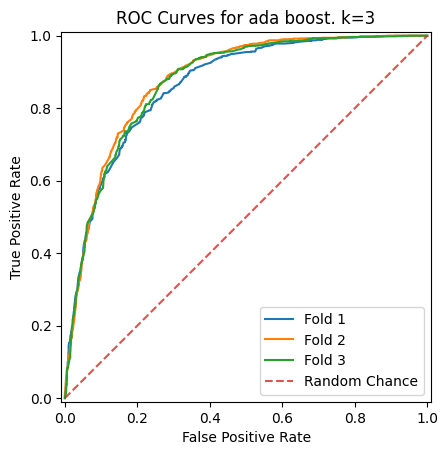

AdaBoost Training Time: 0.90 seconds


In [17]:
# Write your code here
ab_clf = AdaBoostClassifier(n_estimators=25, random_state=23)

# Train AdaBoost model
start_time = time.time()
y_hat_ab = train_and_plot_model(ab_clf, 'ada boost', d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y, k=3)
ab_runtime = time.time() - start_time
print(f"AdaBoost Training Time: {ab_runtime:.2f} seconds")

Training random forest on Fold 1
Training random forest on Fold 2
Training random forest on Fold 3

random forest Performance:
TPR - Min: 0.86, Mean: 0.86, Max: 0.87
PPV - Min: 0.81, Mean: 0.82, Max: 0.83
Accuracy - Min: 0.84, Mean: 0.84, Max: 0.85


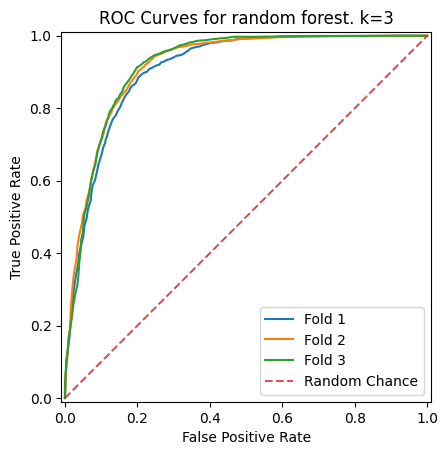

Random Forest Training Time: 4.99 seconds


In [20]:
# Write your code here
rf_clf = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)

# Train Random Forest model
start_time = time.time()
y_hat_rf = train_and_plot_model(rf_clf, 'random forest', d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y, k=3)
rf_runtime = time.time() - start_time
print(f"Random Forest Training Time: {rf_runtime:.2f} seconds")

### **3.2 Compare AdaBoost and Random Forest**  

- **Which model is faster?** Compare the execution times of AdaBoost and Random Forest. Why do you think one is faster than the other?  

- **Which model has better predictive performance?** Compare accuracy, True Positive Rate (TPR), and False Positive Rate (FPR). Which model makes better predictions?  

- **Which model should the bank deploy?** Considering both speed and accuracy, which model is more suitable for the bank’s marketing strategy?


## WRITE ANSWER HERE
- **Answer 1:** AdaBoost is a much faster model, with a training time of 0.90 seconds compared to the RandomForest training time of 4.99 seconds. AdaBoost is likely faster because the max tree depth is set to 1, while RandomForest sets the max number of features equal to sqrt.
- **Answer 2:** RandomForest has better accuracy, TPR, and FPR scores, and the ROC curve looks steeper, so it likely makes better predictions.
- **Answer 3:** If the bank is concerned about speed and wants a less resource-intensive model, then it should use AdaBoost. However, if it wants to maximize accuracy, the bank should use RandomForest.

## **Q4: Implementing XGBoost Classifier**

### **Overview**  
XGBoost (Extreme Gradient Boosting) is one of the most powerful and widely used machine learning algorithms, particularly for structured data tasks. It is an optimized implementation of gradient boosting that improves speed and performance through advanced techniques such as parallel tree boosting, regularization, and efficient handling of missing values.  

XGBoost is known for its ability to:  
- **Handle large datasets efficiently** by leveraging parallel computation.  
- **Prevent overfitting** through L1 (Lasso) and L2 (Ridge) regularization.  
- **Achieve state-of-the-art results** in machine learning competitions such as Kaggle.  
- **Support early stopping** to optimize performance during training.  

For more details on XGBoost, check out the following resources:  
- Official Documentation: [https://xgboost.readthedocs.io/en/stable/](https://xgboost.readthedocs.io/en/stable/)  
- Scikit-learn API for XGBoost: [https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)  
- Gradient Boosting Explanation: [https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)  

You will use **XGBoostClassifier** within the `train_and_plot_model()` function to evaluate its performance on the Bank Marketing Dataset.
-  Also store the time it takes to run the model.


Training XGBoost on Fold 1
Training XGBoost on Fold 2
Training XGBoost on Fold 3

XGBoost Performance:
TPR - Min: 0.76, Mean: 0.77, Max: 0.78
PPV - Min: 0.77, Mean: 0.78, Max: 0.79
Accuracy - Min: 0.78, Mean: 0.79, Max: 0.80


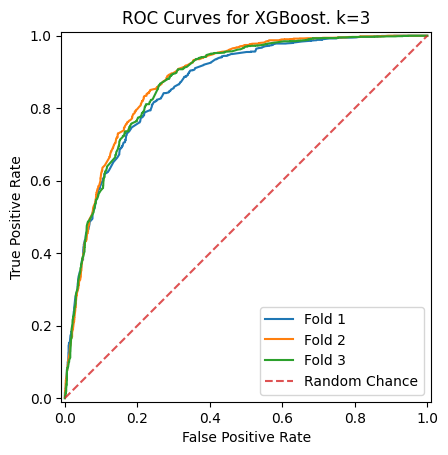

XGBoost Training Time: 1.31 seconds


In [22]:
from xgboost import XGBClassifier

# Train and evaluate XGBoost using the existing function

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1)

start_time = time.time()

y_hat_xgb = train_and_plot_model(ab_clf, 'XGBoost', d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y, k=3)

xg_runtime = time.time() - start_time
print(f"XGBoost Training Time: {xg_runtime:.2f} seconds")

### **Q5 Calculate the Cost of Incorrect Predictions**

The bank is evaluating XGBoost and Random Forest for predicting term deposit subscriptions. Both models have similar accuracy, but XGBoost trains faster.

Since marketing outreach is expensive, the bank wants to estimate the financial impact of False Positives (FP) and False Negatives (FN) before deciding which model to deploy.


**Cost Assumptions:**

* False Positives (FP): $50 (marketing cost per incorrect prediction)

* False Negatives (FN): $500 (lost revenue per missed subscriber)

**Task:**

- Calculate the proportion of customers who subscribed using the dataset.
- Recalculate the True Positive Rate (TPR) and False Positive Rate (FPR) for
XGBoost and Random Forest using their predictions and actual labels.


Using these values, compute:
- The number of False Positives (FP)
- The number of False Negatives (FN)
- Compute the total financial loss for each model.

Considering both financial loss and training time, which model should the bank deploy?


In [24]:
from sklearn.metrics import confusion_matrix

y_pred_xgb = y_hat_xgb  # Predictions from the last fold
y_pred_rf = y_hat_rf  # Predictions from the last fold

# Use correct test labels for the last fold (3rd fold)
fold_index = 3
y_test_xgb = d_test_s_y[fold_index]
y_test_rf = d_test_s_y[fold_index]

# Validate matching lengths
assert len(y_pred_xgb) == len(y_test_xgb), "XGBoost: Mismatch in samples!"
assert len(y_pred_rf) == len(y_test_rf), "Random Forest: Mismatch in samples!"

# Validate matching lengths
assert len(y_pred_xgb) == len(y_test_xgb), f"XGBoost: Mismatch in samples ({len(y_pred_xgb)} vs {len(y_test_xgb)})"
assert len(y_pred_rf) == len(y_test_rf), f"Random Forest: Mismatch in samples ({len(y_pred_rf)} vs {len(y_test_rf)})"

# Compute Confusion Matrices
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)

# Extract TN, FP, FN, TP values
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()

# Compute TPR and FPR fo XGBoost and Random Forest
TPR_xgb = TP_xgb / (TP_xgb + FN_xgb)
FPR_xgb = FP_xgb / (FP_xgb + TN_xgb)

TPR_rf = TP_rf / (TP_rf + FN_rf)
FPR_rf = FP_rf / (FP_rf + TN_rf)

# Calculate the proportion of customers who subscribed
total_customers = len(d_test_s_y)
all_test_labels = pd.concat(list(d_test_s_y.values()))
subscribed_proportion = all_test_labels.mean()
actual_subscribers = TP_xgb + FN_xgb
non_subscribers = total_customers - actual_subscribers

# Define Model Performance
models = {
    "XGBoost": {"TPR": TPR_xgb, "FPR": FPR_xgb, "train_time": xg_runtime},
    "Random Forest": {"TPR": TPR_rf, "FPR": FPR_rf, "train_time": rf_runtime}
}

# Cost Parameters
cost_fp = 50  # Cost of marketing to a non-subscriber
cost_fn = 500  # Revenue lost for missing a true subscriber

# Make dictionary for confusion matrices
cm_dict = {'XGBoost': {'TP':TP_xgb, 'FP': FP_xgb, 'FN': FN_xgb},
           'Random Forest': {'TP':TP_rf, 'FP': FP_rf, 'FN': FN_rf}
           }

# Compute FP, FN, and total cost
for model, metrics in cm_dict.items():
    TP = cm_dict[model]['TP']
    FP = cm_dict[model]['FP']
    FN = cm_dict[model]['FN']

    total_cost = (FP * cost_fp) + (FN * cost_fn)

    print(f"{model}: False Positives = {FP:.0f}, False Negatives = {FN:.0f}, Total Cost = ${total_cost:,.2f}")



XGBoost: False Positives = 405, False Negatives = 394, Total Cost = $217,250.00
Random Forest: False Positives = 322, False Negatives = 243, Total Cost = $137,600.00
